# EEG Alpha Decoding Curve Across Time Windows Using CSP and LDA

> **Note:** This script takes about 12 minutes to run. Hyperparamter: n_comp; channels aterior to FC were omitted due to potential bridging

This script evaluates how decoding accuracy from EEG alpha band power changes as a function of the temporal integration window. It combines Common Spatial Patterns (CSP) for feature extraction with Linear Discriminant Analysis (LDA) for classification, using cross-validation on data from multiple subjects.

---

## **1. Data Loading and Preprocessing**
- **Import and Directory Setup:**
  - Sets up the working directory and paths to the data, derivatives, analysis, and results directories.
  - Configures MNE to minimize log messages during execution.

- **Channel and Subject Specifications:**
  - A list of subjects and a full set of EEG channels (`picks_hubner`) are defined.
  - Channels deemed noisy for specific subjects (defined in `subjects_channel_reject`) are removed on a per-subject basis.

- **Signal Filtering and Artifact Removal:**
  - **Bandpass Filtering:**  
    A Butterworth filter (8–12 Hz) is applied to isolate the alpha band using the `bandpass_filter` function.
  - **Edge Artifact Removal:**  
    The script removes the first and last 120 samples of the signal to avoid filter-induced artifacts.
  - **Feature Extraction:**  
    The `compute_average_hilbert_amplitude` function computes the log-transformed mean amplitude over time using the Hilbert transform. This provides a compact measure of alpha power per trial and channel.

---

## **2. Decoding Pipeline with CSP and LDA**
- **Time Window Integration:**
  - The script tests multiple integration windows defined by the variable `amount_integrated_time` (ranging from 5 to 80 in steps, interpreted as multiples of 30 ms).
  - For each window, only a portion of the time samples (i.e., the first `int(30 * window)` samples) of the preprocessed data is used. This tests how the integration period affects decoding performance.

- **CSP for Feature Extraction:**
  - **Initialization:**  
    A CSP object is created with a specified number of components (`n_comp = 6`) to transform the EEG data into a spatial feature space that maximizes variance differences between the conditions.
  - **Application:**  
    The CSP transformation is applied separately on the training and testing sets within the cross-validation loop.

- **Classification with LDA:**
  - **Model Setup:**  
    LDA is initialized with a covariance estimator (Ledoit-Wolf regularization) to improve stability.
  - **Cross-Validation:**  
    For each integration window and subject, the data is split into four folds. For each fold:
    - CSP is fitted on the training data.
    - Both training and testing data are transformed using the fitted CSP.
    - Log-transformed Hilbert amplitude features are computed from the CSP-transformed data.
    - LDA is trained on the training features and then used to predict labels on the test set.
    - Accuracy is calculated for each fold.
  - **Result Aggregation:**  
    The average accuracy per subject for each time window is computed and then collected across all subjects.

---

## **3. Group-Level Analysis and Results Saving**
- **Results Calculation:**
  - For each integration window, the script computes:
    - **Group Mean Accuracy:** Mean of subject accuracies across all subjects contributing data.
    - **Standard Error:** Estimated as the standard deviation across subjects divided by the square root of the number of subjects.
  - These results (time window, mean accuracy, and standard error) are compiled into a structured NumPy array.

- **Storage:**
  - The final results are saved in the designated decoding results directory using NumPy's `.npy` format.

---

## **4. Purpose and Applications**
- **Objective:**  
  To assess the effect of computing the alpha band feature vector from virtual channels as craeted by CSP as opposed to using a sub-set of physical channels.


---

## **Execution Details**
- The script processes each subject's data file (if available), applies channel cleaning, filters the signal, and performs cross-validation using CSP and LDA.
- The process is repeated over multiple integration window sizes, accumulating performance metrics at the group level.
- The overall results are output as a NumPy array for easy further analysis or visualization.


In [1]:
import os
import numpy as np
from scipy.signal import butter, sosfilt, hilbert
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.covariance import LedoitWolf
from sklearn.metrics import accuracy_score
from mne.decoding import CSP
from os.path import join
import mne

mne.set_log_level('warning')

wd = r'C:\Users\Radovan\OneDrive\Radboud\Studentships\Jordy Thielen\root'
os.chdir(wd)
data_dir = join(wd, "data")
experiment_dir = join(data_dir, "experiment")
files_dir = join(experiment_dir, 'files')
sourcedata_dir = join(experiment_dir, 'sourcedata')
derivatives_dir = join(join(experiment_dir, 'derivatives'))
analysis_dir = join(data_dir, "analysis")
alpha_dir = join(analysis_dir, "alpha")
decoding_results_dir = join(alpha_dir, "decoding_results") 
plots_dir = join(alpha_dir, "plots")
features_dir = join(alpha_dir, "plots", "features")

# Define helper funcitons
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    """
    Apply a bandpass filter to the data.
    """
    sos = butter(order, [lowcut, highcut], btype='band', fs=fs, output='sos')
    return sosfilt(sos, data, axis=-1)

def compute_average_hilbert_amplitude(data):
    """
    Compute log-mean amplitude using Hilbert transform.
    """
    analytic = hilbert(data, axis=2)
    amplitude = np.abs(analytic)
    mean_amplitude = amplitude.mean(axis=2)
    return np.log(mean_amplitude)

# List of subjects and channels
subjects = [
    "VPpdia", "VPpdib", "VPpdic", "VPpdid", "VPpdie", "VPpdif", "VPpdig", "VPpdih",
    "VPpdii", "VPpdij", "VPpdik", "VPpdil", "VPpdim", "VPpdin", "VPpdio", "VPpdip",
    "VPpdiq", "VPpdir", "VPpdis", "VPpdit", "VPpdiu", "VPpdiv", "VPpdiw", "VPpdix",
    "VPpdiy", "VPpdiz", "VPpdiza", "VPpdizb", "VPpdizc"
    ]
picks_hubner = [
    "F7", "F3", "Fz", "F4", "F8", "FC1", "FC2", "FC5", "FC6", "FCz", "T7", "C3", 
    "Cz", "C4", "T8", "CP1", "CP2", "CP5", "CP6", "CPz",
    "P7", "P3", "Pz", "P4", "P8", "Oz", "O1", "O2"
]
subjects_channel_reject = {
    "VPpdib": ["CP2"],
    "VPpdih": ["C3"],
    "VPpdizb": ["Fz"],
    "VPpdizc": ["FC2"]
}

task = "covert"

# Define number of integrated epochs
amount_integrated_time = np.linspace(5, 80, 16, dtype=int)

# Here accumulate all accuracies (across subjects) per time window in a dictionary
#   key = window size
#   value = list of cross-validation accuracies from all subjects
group_accuracies_per_window = {}

# Loop through subjects
for subject in subjects:

    file_dir = os.path.join(derivatives_dir, 'preprocessed', "alpha", f"sub-{subject}")
    file_path = os.path.join(file_dir, f"sub-{subject}_task-{task}_alpha.npz")
    # Check if file exists
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue
    
    #Clean channels
    picks_clean = picks_hubner.copy()
    
    #Adapt indexing for rejected channels
    if subject in subjects_channel_reject:
        # Get the channels to reject for this subject
        channels_to_reject = subjects_channel_reject[subject]
        # Remove all channels from picks_clean
        for channel in channels_to_reject:
            if channel in picks_clean:
                picks_clean.remove(channel)

    # Load data
    npz_data = np.load(file_path)
    X = npz_data['X']  # EEG data: trials x channels x samples
    y = npz_data['y']  # Labels: trials
    fs = npz_data['fs']  # Sampling frequency
    # turn array to integer
    fs = fs.flatten()[0]

    # Preprocess data, sub-select channels used in this run
    selected_channels = ["FC1", "FC2", "FC5", "FC6", "FCz", "T7", "C3", 
    "Cz", "C4", "T8", "CP1", "CP2", "CP5", "CP6", "CPz",
    "P7", "P3", "Pz", "P4", "P8", "Oz", "O1", "O2"]

    selected_indices = [picks_clean.index(ch) for ch in selected_channels if ch in picks_clean]

    X = X[:, selected_indices, :]  # Crop to selected channels
    # Preprocess data
    X = bandpass_filter(X, 8, 12, fs=fs)  # Bandpass filter for alpha band
    X = X[:, :, 120:-120]  # Remove edge artifacts

    # Initialize CSP and LDA
    n_comp = 6
    csp = CSP(n_components=n_comp, log=None, transform_into='csp_space')
    lda = LDA(solver="lsqr", covariance_estimator=LedoitWolf())

    for window in amount_integrated_time:
        window_data = X[:, :, :int(30 * window)]  # Stimulus every 30 ms
        
        # Cross-validation
        fold_accuracies = []
        n_folds = 4
        n_trials = X.shape[0] // n_folds
        folds = np.repeat(np.arange(n_folds), n_trials)

        for i_fold in range(n_folds):
            # Train-test split
            X_trn, y_trn = window_data[folds != i_fold], y[folds != i_fold]
            X_tst, y_tst = window_data[folds == i_fold], y[folds == i_fold]
            
            # CSP and LDA
            csp.fit(X_trn, y_trn)
            X_trn_csp = compute_average_hilbert_amplitude(csp.transform(X_trn))
            lda.fit(X_trn_csp, y_trn)

            X_tst_csp = compute_average_hilbert_amplitude(csp.transform(X_tst))
            # Predict and compute accuracy
            y_pred = lda.predict(X_tst_csp)

            accuracy = accuracy_score(y_tst, y_pred)
            fold_accuracies.append(accuracy)

            # Compute subject-level results
        subject_mean_accuracy = np.mean(fold_accuracies)

        # Accumulate these accuracies for the group
        if window not in group_accuracies_per_window:
            group_accuracies_per_window[window] = []
        group_accuracies_per_window[window].append(subject_mean_accuracy)

results_list = []
for window in sorted(group_accuracies_per_window.keys()):
    subject_accuracies = group_accuracies_per_window[window]
    
    # Group-level mean accuracy
    mean_accuracy = np.mean(subject_accuracies)
    
    # Standard error across subjects
    # (N = number of subjects who contributed data for that window)
    n_subjects = len(subject_accuracies)
    se_accuracy = np.std(subject_accuracies) / np.sqrt(n_subjects)
    
    # Append tuple for later conversion
    results_list.append((window, mean_accuracy, se_accuracy))

# Convert to a structured NumPy array
results_array = np.array(
    results_list,
    dtype=[
        ('time_window', '<i4'),
        ('mean_accuracy', '<f4'),
        ('standard_error', '<f4'),
    ]
)


if not os.path.exists(decoding_results_dir):
        os.makedirs(decoding_results_dir)
        
np.save(join(decoding_results_dir, f"{task}_lda_CSP_decC_results"), results_array)

### Plot performance

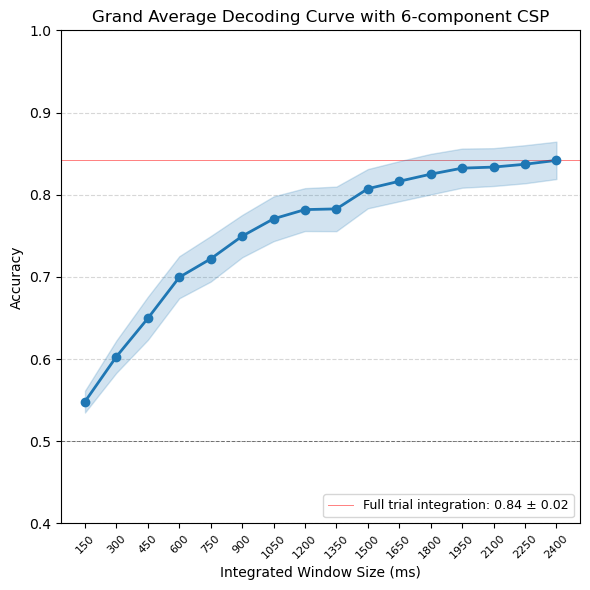

In [5]:
import matplotlib.pyplot as plt
time_windows   = results_array['time_window']
mean_accuracies = results_array['mean_accuracy']
mean_ses        = results_array['standard_error']

# It's good practice to sort by time_window (in case they're not already).
sort_idx       = np.argsort(time_windows)
time_windows   = time_windows[sort_idx]
mean_accuracies = mean_accuracies[sort_idx]
mean_ses        = mean_ses[sort_idx]

# Make a plot
plt.figure(figsize=(6, 6))

# Line plot for decoding accuracy
plt.plot(time_windows * 30, mean_accuracies, color='tab:blue', lw=2)

# Add dots for each data point
plt.scatter(time_windows * 30, mean_accuracies, color='tab:blue', zorder=3)

# Shaded area for standard error
plt.fill_between(
    time_windows * 30, 
    mean_accuracies - mean_ses, 
    mean_accuracies + mean_ses, 
    color='tab:blue', alpha=0.2, zorder=3
)

# Customize the plot
plt.title(f'Grand Average Decoding Curve with {n_comp}-component CSP', fontsize=12)
plt.xlabel('Integrated Window Size (ms)', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.ylim(0.4, 1.0)
plt.yticks(np.arange(0.4, 1.1, 0.1))
# The below assumes you used the same time window logic: 5–80 in steps of 16
plt.xticks(np.linspace(5, 80, 16, dtype=int)*30, fontsize=8, rotation=45)

plt.axhline(0.5, color='k', linestyle='--', alpha=0.5, linewidth=0.7)
plt.axhline(mean_accuracies[-1], color='red', linestyle='-', linewidth=0.7, 
            label=f'Full trial integration: {mean_accuracies[-1]:.2f} ± {mean_ses[-1]:.2f}',
            alpha=0.5)
plt.legend(fontsize=9, loc='lower right')
plt.grid(alpha=0.5, linestyle='--', axis='y')
plt.tight_layout()
plt.savefig(join(plots_dir, f"{task}_lda_alpha_{n_comp}-comp_CSP_decC_results.png"), dpi=300)
plt.savefig(join(plots_dir, f"{task}_lda_alpha_{n_comp}-comp_CSP_decC_results.svg"), dpi=300)
plt.close()